In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
#preprocessing data
def create_sample_historical_data():
    """Create sample historical data matching the provided format"""
    print("Creating sample historical data...")

    dates = pd.date_range('2022-01-01', '2024-12-31', freq='H')
    
    def is_nerc_holiday(date):
        holidays = [(1, 1), (5, 31), (9, 5), (11, 24), (12, 25)]
        return (date.month, date.day) in holidays
    
    def generate_wind_generation(date, market):
        seasonal = np.sin(2 * np.pi * (date.dayofyear / 365.25 - 0.25)) * 0.4
        diurnal = np.sin(2 * np.pi * (date.hour / 24 + 0.3)) * 0.3
        random_comp = np.random.normal(0, 0.15)
        base_gen = 0.4 + seasonal + diurnal + random_comp
        base_gen = np.clip(base_gen, 0, 1)
        return base_gen * 100
    
    def generate_solar_generation(date, market):
        if date.hour < 6 or date.hour > 19:
            return 0.0
        hour_relative = (date.hour - 6) / 12
        diurnal = np.sin(np.pi * hour_relative) ** 1.5
        seasonal = np.sin(2 * np.pi * (date.dayofyear / 365.25 - 0.5)) * 0.3 + 0.7
        random_comp = np.random.normal(0, 0.1)
        base_gen = diurnal * seasonal + random_comp
        base_gen = np.clip(base_gen, 0, 1)
        return base_gen * 100
    
    def generate_prices(date, market, is_peak, generation):
        base_prices = {'ERCOT': 45, 'MISO': 35, 'CAISO': 55}
        base = base_prices[market] if is_peak else base_prices[market] * 0.6
        
        hour_effect = np.sin(2 * np.pi * date.hour / 24) * 10
        seasonal_effect = np.sin(2 * np.pi * date.dayofyear / 365.25) * 15
        ren_effect = -generation / 100 * 5
        volatility = np.random.normal(0, base * 0.3)
        
        rt_price = base + hour_effect + seasonal_effect + ren_effect + volatility
        if generation > 80 and not is_peak and np.random.random() < 0.03:
            rt_price = -np.random.uniform(1, 5)
        
        da_price = rt_price * np.random.normal(1, 0.1)
        rt_hub = rt_price * np.random.normal(1, 0.05)
        da_hub = da_price * np.random.normal(1, 0.05)
        
        return round(rt_price, 2), round(rt_hub, 2), round(da_price, 2), round(da_hub, 2)
    assets_data = {}
    #ERCOT
    print("  Generating Valentino_ERCOT data...")
    valentino_data = []
    for date in dates[:1000]:  # First 1000 hours for demo
        is_weekday = date.weekday() < 5
        is_holiday = is_nerc_holiday(date)
        is_peak = (is_weekday and not is_holiday and date.hour >= 6 and date.hour <= 21)
        p_op = 'P' if is_peak else 'OP'
        
        gen = generate_wind_generation(date, 'ERCOT')
        rt_busbar, rt_hub, da_busbar, da_hub = generate_prices(date, 'ERCOT', is_peak, gen)
        
        valentino_data.append({
            'Date': date.strftime('%d-%b-%y'),
            'HE': date.hour + 1,
            'P/OP': p_op,
            'Gen': round(gen, 1),
            'RT Busbar': rt_busbar,
            'RT Hub': rt_hub,
            'DA Busbar': da_busbar,
            'DA Hub': da_hub
        })
    assets_data['Valentino_ERCOT'] = valentino_data
    
    #MISO
    print("  Generating Mantero_MISO data...")
    mantero_data = []
    for date in dates[:1000]:
        is_weekday = date.weekday() < 5
        is_holiday = is_nerc_holiday(date)
        is_peak = (is_weekday and not is_holiday and date.hour >= 6 and date.hour <= 21)
        p_op = 'P' if is_peak else 'OP'
        
        gen = generate_wind_generation(date, 'MISO')
        rt_busbar, rt_hub, da_busbar, da_hub = generate_prices(date, 'MISO', is_peak, gen)
        
        mantero_data.append({
            'Date': date.strftime('%d-%b-%y'),
            'HE': date.hour + 1,
            'P/OP': p_op,
            'Gen': round(gen, 1),
            'RT Busbar': rt_busbar,
            'RT Hub': rt_hub,
            'DA Busbar': da_busbar,
            'DA Hub': da_hub
        })
    assets_data['Mantero_MISO'] = mantero_data
    
    #CAISO
    print("  Generating Howling_Gale_CAISO data...")
    howling_data = []
    for date in dates[:1000]:
        is_weekday = date.weekday() < 5
        is_holiday = is_nerc_holiday(date)
        is_peak = (is_weekday and not is_holiday and date.hour >= 6 and date.hour <= 21)
        p_op = 'P' if is_peak else 'OP'
        
        gen = generate_solar_generation(date, 'CAISO')
        rt_busbar, rt_hub, da_busbar, da_hub = generate_prices(date, 'CAISO', is_peak, gen)
        
        howling_data.append({
            'Date': date.strftime('%d-%b-%y'),
            'HE': date.hour + 1,
            'P/OP': p_op,
            'Gen': round(gen, 1),
            'RT Busbar': rt_busbar,
            'RT Hub': rt_hub,
            'DA Busbar': da_busbar,
            'DA Hub': da_hub
        })
    assets_data['Howling_Gale_CAISO'] = howling_data
    
    print("✓ Sample historical data created successfully")
    return assets_data

def create_forward_curves():
    """Create sample forward price curves"""
    print("Creating forward price curves...")
    
    forward_curves = {
        'ERCOT': {
            'months': ['Jan-26', 'Feb-26', 'Mar-26', 'Apr-26', 'May-26', 'Jun-26', 
                      'Jul-26', 'Aug-26', 'Sep-26', 'Oct-26', 'Nov-26', 'Dec-26'],
            'peak': [66.41, 66.38, 47.90, 47.59, 49.00, 52.13, 79.10, 112.37, 60.22, 44.56, 45.37, 51.64],
            'off_peak': [61.71, 59.84, 37.77, 36.67, 37.22, 39.89, 50.15, 66.49, 42.00, 36.83, 36.62, 41.75]
        },
        'MISO': {
            'months': ['Jan-26', 'Feb-26', 'Mar-26', 'Apr-26', 'May-26', 'Jun-26', 
                      'Jul-26', 'Aug-26', 'Sep-26', 'Oct-26', 'Nov-26', 'Dec-26'],
            'peak': [x * 0.85 for x in [66.41, 66.38, 47.90, 47.59, 49.00, 52.13, 79.10, 112.37, 60.22, 44.56, 45.37, 51.64]],
            'off_peak': [x * 0.85 for x in [61.71, 59.84, 37.77, 36.67, 37.22, 39.89, 50.15, 66.49, 42.00, 36.83, 36.62, 41.75]]
        },
        'CAISO': {
            'months': ['Jan-26', 'Feb-26', 'Mar-26', 'Apr-26', 'May-26', 'Jun-26', 
                      'Jul-26', 'Aug-26', 'Sep-26', 'Oct-26', 'Nov-26', 'Dec-26'],
            'peak': [x * 1.15 for x in [66.41, 66.38, 47.90, 47.59, 49.00, 52.13, 79.10, 112.37, 60.22, 44.56, 45.37, 51.64]],
            'off_peak': [x * 1.15 for x in [61.71, 59.84, 37.77, 36.67, 37.22, 39.89, 50.15, 66.49, 42.00, 36.83, 36.62, 41.75]]
        }
    }
    
    print("✓ Forward curves created successfully")
    return forward_curves
historical_data = create_sample_historical_data()
forward_curves = create_forward_curves()

print(f"Created data for {len(historical_data)} assets")
for asset_name, data in historical_data.items():
    print(f"  {asset_name}: {len(data)} hourly records")

Creating sample historical data...
  Generating Valentino_ERCOT data...
  Generating Mantero_MISO data...
  Generating Howling_Gale_CAISO data...
✓ Sample historical data created successfully
Creating forward price curves...
✓ Forward curves created successfully
Created data for 3 assets
  Valentino_ERCOT: 1000 hourly records
  Mantero_MISO: 1000 hourly records
  Howling_Gale_CAISO: 1000 hourly records


In [ ]:
#cleaning data
def process_historical_data(historical_data):
    """Process and clean historical data"""
    print("Processing historical data...")
    
    processed_data = {}
    
    for asset_name, data_list in historical_data.items():
        df = pd.DataFrame(data_list)
        numeric_cols = ['Gen', 'RT Busbar', 'RT Hub', 'DA Busbar', 'DA Hub']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df['Hourly_Revenue'] = df['Gen'] * df['RT Busbar']
        df['Negative_Price_Event'] = df['RT Busbar'] < 0
        df['Date'] = pd.to_datetime(df['Date'])
        
        processed_data[asset_name] = df
        
        print(f"  {asset_name}: Processed {len(df)} records")
        print(f"    - Avg Generation: {df['Gen'].mean():.1f} MW")
        print(f"    - Avg RT Price: ${df['RT Busbar'].mean():.2f}/MWh")
        print(f"    - Negative Price Events: {df['Negative_Price_Event'].sum()}")
    
    print("✓ Historical data processing completed")
    return processed_data

def calculate_historical_metrics(processed_data):
    """Calculate comprehensive historical metrics"""
    print("Calculating historical metrics...")
    
    historical_metrics = {}
    
    for asset_name, df in processed_data.items():
        metrics = {
            'Data_Points': len(df),
            'Avg_Generation_MW': df['Gen'].mean(),
            'Capacity_Factor': df['Gen'].mean() / 100,  # Assuming 100 MW capacity
            'Avg_RT_Price': df['RT Busbar'].mean(),
            'Avg_DA_Price': df['DA Busbar'].mean(),
            'Price_Volatility': df['RT Busbar'].std(),
            'Negative_Price_Hours': df['Negative_Price_Event'].sum(),
            'Negative_Price_Pct': df['Negative_Price_Event'].mean() * 100,
            'Total_Revenue': df['Hourly_Revenue'].sum(),
            'Avg_Revenue_MWh': df['Hourly_Revenue'].sum() / df['Gen'].sum() if df['Gen'].sum() > 0 else 0,
            'Peak_Avg_Price': df[df['P/OP'] == 'P']['RT Busbar'].mean(),
            'OffPeak_Avg_Price': df[df['P/OP'] == 'OP']['RT Busbar'].mean(),
            'Peak_Capacity_Factor': df[df['P/OP'] == 'P']['Gen'].mean() / 100,
            'OffPeak_Capacity_Factor': df[df['P/OP'] == 'OP']['Gen'].mean() / 100,
            'Max_Price': df['RT Busbar'].max(),
            'Min_Price': df['RT Busbar'].min()
        }
        
        historical_metrics[asset_name] = metrics
        
        print(f"  {asset_name}:")
        print(f"    - Capacity Factor: {metrics['Capacity_Factor']:.1%}")
        print(f"    - Negative Price %: {metrics['Negative_Price_Pct']:.1f}%")
        print(f"    - Total Revenue: ${metrics['Total_Revenue']:,.0f}")
    
    print("✓ Historical metrics calculation completed")
    return historical_metrics
processed_data = process_historical_data(historical_data)
historical_metrics = calculate_historical_metrics(processed_data)

Processing historical data...
  Valentino_ERCOT: Processed 1000 records
    - Avg Generation: 12.8 MW
    - Avg RT Price: $40.20/MWh
    - Negative Price Events: 1
  Mantero_MISO: Processed 1000 records
    - Avg Generation: 12.5 MW
    - Avg RT Price: $32.53/MWh
    - Negative Price Events: 1
  Howling_Gale_CAISO: Processed 1000 records
    - Avg Generation: 17.6 MW
    - Avg RT Price: $48.05/MWh
    - Negative Price Events: 0
✓ Historical data processing completed
Calculating historical metrics...
  Valentino_ERCOT:
    - Capacity Factor: 12.8%
    - Negative Price %: 0.1%
    - Total Revenue: $439,039
  Mantero_MISO:
    - Capacity Factor: 12.5%
    - Negative Price %: 0.1%
    - Total Revenue: $337,178
  Howling_Gale_CAISO:
    - Capacity Factor: 17.6%
    - Negative Price %: 0.0%
    - Total Revenue: $849,905
✓ Historical metrics calculation completed


In [ ]:
#Risk Analysis 
def calculate_risk_metrics(processed_data):
    """Calculate risk metrics including VaR and CVaR"""
    print("Calculating risk metrics...")
    
    risk_metrics = {}
    
    for asset_name, df in processed_data.items():
        revenue_per_mwh = df[df['Gen'] > 0]['Hourly_Revenue'] / df[df['Gen'] > 0]['Gen']
        var_95 = np.percentile(revenue_per_mwh, 5)
        cvar_95 = revenue_per_mwh[revenue_per_mwh <= var_95].mean()
    
        negative_events = df[df['RT Busbar'] < 0]
        negative_revenue_impact = negative_events['Hourly_Revenue'].sum()
        
        metrics = {
            'VaR_95': var_95,
            'CVaR_95': cvar_95,
            'Max_Drawdown': revenue_per_mwh.min(),
            'Negative_Revenue_Impact': negative_revenue_impact,
            'Revenue_Volatility': revenue_per_mwh.std(),
            'Sharpe_Ratio': revenue_per_mwh.mean() / revenue_per_mwh.std() if revenue_per_mwh.std() > 0 else 0,
            'Negative_Event_Count': len(negative_events),
            'Worst_Hour_Revenue': df['Hourly_Revenue'].min()
        }
        
        risk_metrics[asset_name] = metrics
        
        print(f"  {asset_name}:")
        print(f"    - VaR 95%: ${metrics['VaR_95']:.2f}/MWh")
        print(f"    - CVaR 95%: ${metrics['CVaR_95']:.2f}/MWh")
        print(f"    - Negative Revenue Impact: ${metrics['Negative_Revenue_Impact']:,.0f}")
        print(f"    - Sharpe Ratio: {metrics['Sharpe_Ratio']:.3f}")
    
    print("✓ Risk metrics calculation completed")
    return risk_metrics
risk_metrics = calculate_risk_metrics(processed_data)

Calculating risk metrics...
  Valentino_ERCOT:
    - VaR 95%: $15.85/MWh
    - CVaR 95%: $11.53/MWh
    - Negative Revenue Impact: $0
    - Sharpe Ratio: 2.561
  Mantero_MISO:
    - VaR 95%: $11.09/MWh
    - CVaR 95%: $7.49/MWh
    - Negative Revenue Impact: $-1
    - Sharpe Ratio: 2.591
  Howling_Gale_CAISO:
    - VaR 95%: $23.45/MWh
    - CVaR 95%: $16.92/MWh
    - Negative Revenue Impact: $0
    - Sharpe Ratio: 2.665
✓ Risk metrics calculation completed


In [ ]:
#Revenue Forecast
def forecast_future_revenues(historical_metrics, risk_metrics, forward_curves, years=5):
    """Forecast future revenues with risk adjustments"""
    print("Forecasting future revenues...")
    
    forecast_results = {}
    
    for asset_name in historical_metrics.keys():
        market = asset_name.split('_')[-1]
        hist_metrics = historical_metrics[asset_name]
        risk_metrics_asset = risk_metrics[asset_name]
        fwd_data = forward_curves[market]
        fwd_peak = fwd_data['peak'][:years]
        fwd_offpeak = fwd_data['off_peak'][:years]
        peak_hours_ratio = (16/24) * (5/7)
        offpeak_hours_ratio = 1 - peak_hours_ratio

        annual_gen_mwh = hist_metrics['Avg_Generation_MW'] * 365 * 24
        avg_fwd_price = (np.mean(fwd_peak) * peak_hours_ratio + 
                       np.mean(fwd_offpeak) * offpeak_hours_ratio)
        base_revenue = annual_gen_mwh * avg_fwd_price * years
    
        var_adjustment = abs(risk_metrics_asset['CVaR_95']) * annual_gen_mwh * years * 0.1
        annual_negative_impact = risk_metrics_asset['Negative_Revenue_Impact'] / (hist_metrics['Data_Points'] / (365 * 24)) * years
        negative_adjustment = abs(annual_negative_impact)
        volatility_adjustment = risk_metrics_asset['Revenue_Volatility'] * annual_gen_mwh * years * 0.05
        
        total_risk_adjustment = var_adjustment + negative_adjustment + volatility_adjustment
        risk_adjusted_revenue = base_revenue - total_risk_adjustment
        risk_adjusted_price = risk_adjusted_revenue / (annual_gen_mwh * years)
        
        forecast_results[asset_name] = {
            'Base_Expected_Revenue': base_revenue,
            'Risk_Adjusted_Revenue': risk_adjusted_revenue,
            'Risk_Adjusted_Price_MWh': risk_adjusted_price,
            'Base_Forward_Price_MWh': avg_fwd_price,
            'Risk_Premium_MWh': avg_fwd_price - risk_adjusted_price,
            'Total_Risk_Adjustment': total_risk_adjustment,
            'Annual_Generation_MWh': annual_gen_mwh,
            'Expected_Annual_Revenue': base_revenue / years
        }
        
        print(f"  {asset_name}:")
        print(f"    - Base Forward Price: ${avg_fwd_price:.2f}/MWh")
        print(f"    - Risk Adjusted Price: ${risk_adjusted_price:.2f}/MWh")
        print(f"    - Risk Premium: ${forecast_results[asset_name]['Risk_Premium_MWh']:.2f}/MWh")
        print(f"    - 5-Year Risk Adj Revenue: ${risk_adjusted_revenue:,.0f}")
    
    print("✓ Revenue forecasting completed")
    return forecast_results
forecast_results = forecast_future_revenues(historical_metrics, risk_metrics, forward_curves, years=5)

Forecasting future revenues...
  Valentino_ERCOT:
    - Base Forward Price: $50.84/MWh
    - Risk Adjusted Price: $48.99/MWh
    - Risk Premium: $1.85/MWh
    - 5-Year Risk Adj Revenue: $27,544,515
  Mantero_MISO:
    - Base Forward Price: $43.21/MWh
    - Risk Adjusted Price: $41.91/MWh
    - Risk Premium: $1.30/MWh
    - 5-Year Risk Adj Revenue: $22,911,373
  Howling_Gale_CAISO:
    - Base Forward Price: $58.47/MWh
    - Risk Adjusted Price: $55.79/MWh
    - Risk Premium: $2.68/MWh
    - 5-Year Risk Adj Revenue: $42,975,407
✓ Revenue forecasting completed


In [ ]:
#Hedge Analysis
def analyze_hedging_decisions(forecast_results, historical_metrics, risk_metrics, fixed_price_offers=None):
    """Analyze whether to accept fixed price offers or remain merchant"""
    print("Analyzing hedging decisions...")
    
    if fixed_price_offers is None:
        fixed_price_offers = {
            'Valentino_ERCOT': 42.0,
            'Mantero_MISO': 38.0,
            'Howling_Gale_CAISO': 48.0
        }
    
    decisions = {}
    
    for asset_name, forecast in forecast_results.items():
        fixed_offer = fixed_price_offers.get(asset_name, 0)
        risk_adj_price = forecast['Risk_Adjusted_Price_MWh']
        base_forward = forecast['Base_Forward_Price_MWh']
        
        price_difference = fixed_offer - risk_adj_price
        percent_difference = (price_difference / risk_adj_price) * 100
        
        risk_metrics_asset = risk_metrics[asset_name]
        negative_event_pct = historical_metrics[asset_name]['Negative_Price_Pct']
        
        if fixed_offer > risk_adj_price:
            recommendation = "ACCEPT fixed price offer"
            confidence = "High" if percent_difference > 7 else "Moderate"
        else:
            if risk_metrics_asset['Revenue_Volatility'] / risk_adj_price < 0.4 and negative_event_pct < 2:
                recommendation = "CONSIDER remaining merchant"
                confidence = "Moderate"
            else:
                recommendation = "SEEK better fixed price offer"
                confidence = "High"
        
        decisions[asset_name] = {
            'Fixed_Price_Offer': fixed_offer,
            'Risk_Adjusted_Price': risk_adj_price,
            'Base_Forward_Price': base_forward,
            'Price_Difference': price_difference,
            'Percent_Difference': percent_difference,
            'Recommendation': recommendation,
            'Confidence': confidence,
            'Negative_Price_Frequency': negative_event_pct,
            'Revenue_Volatility': risk_metrics_asset['Revenue_Volatility']
        }
        
        print(f"  {asset_name}:")
        print(f"    - Fixed Offer: ${fixed_offer:.2f}/MWh")
        print(f"    - Risk Adj Price: ${risk_adj_price:.2f}/MWh")
        print(f"    - Difference: ${price_difference:.2f}/MWh ({percent_difference:+.1f}%)")
        print(f"    - RECOMMENDATION: {recommendation}")
    
    print("✓ Hedging analysis completed")
    return decisions
decisions = analyze_hedging_decisions(forecast_results, historical_metrics, risk_metrics)

Analyzing hedging decisions...
  Valentino_ERCOT:
    - Fixed Offer: $42.00/MWh
    - Risk Adj Price: $48.99/MWh
    - Difference: $-6.99/MWh (-14.3%)
    - RECOMMENDATION: CONSIDER remaining merchant
  Mantero_MISO:
    - Fixed Offer: $38.00/MWh
    - Risk Adj Price: $41.91/MWh
    - Difference: $-3.91/MWh (-9.3%)
    - RECOMMENDATION: CONSIDER remaining merchant
  Howling_Gale_CAISO:
    - Fixed Offer: $48.00/MWh
    - Risk Adj Price: $55.79/MWh
    - Difference: $-7.79/MWh (-14.0%)
    - RECOMMENDATION: CONSIDER remaining merchant
✓ Hedging analysis completed



MERCHANT RENEWABLE ASSET VALUATION REPORT

ASSET OVERVIEW:
----------------------------------------
• Valentino_ERCOT (Wind - ERCOT)
• Mantero_MISO (Wind - MISO)
• Howling_Gale_CAISO (Solar - CAISO)

HISTORICAL PERFORMANCE (Sample Analysis):
--------------------------------------------------

Valentino_ERCOT:
  Average Generation: 12.8 MW
  Capacity Factor: 12.8%
  Average Real-Time Price: $40.20/MWh
  Price Volatility: $15.96/MWh
  Negative Price Events: 1 hours (0.1%)

Mantero_MISO:
  Average Generation: 12.5 MW
  Capacity Factor: 12.5%
  Average Real-Time Price: $32.53/MWh
  Price Volatility: $13.17/MWh
  Negative Price Events: 1 hours (0.1%)

Howling_Gale_CAISO:
  Average Generation: 17.6 MW
  Capacity Factor: 17.6%
  Average Real-Time Price: $48.05/MWh
  Price Volatility: $18.08/MWh
  Negative Price Events: 0 hours (0.0%)

RISK ASSESSMENT:
------------------------------

Valentino_ERCOT:
  Value at Risk (95%): $15.85/MWh
  Conditional VaR: $11.53/MWh
  Revenue Volatility: $14.00/

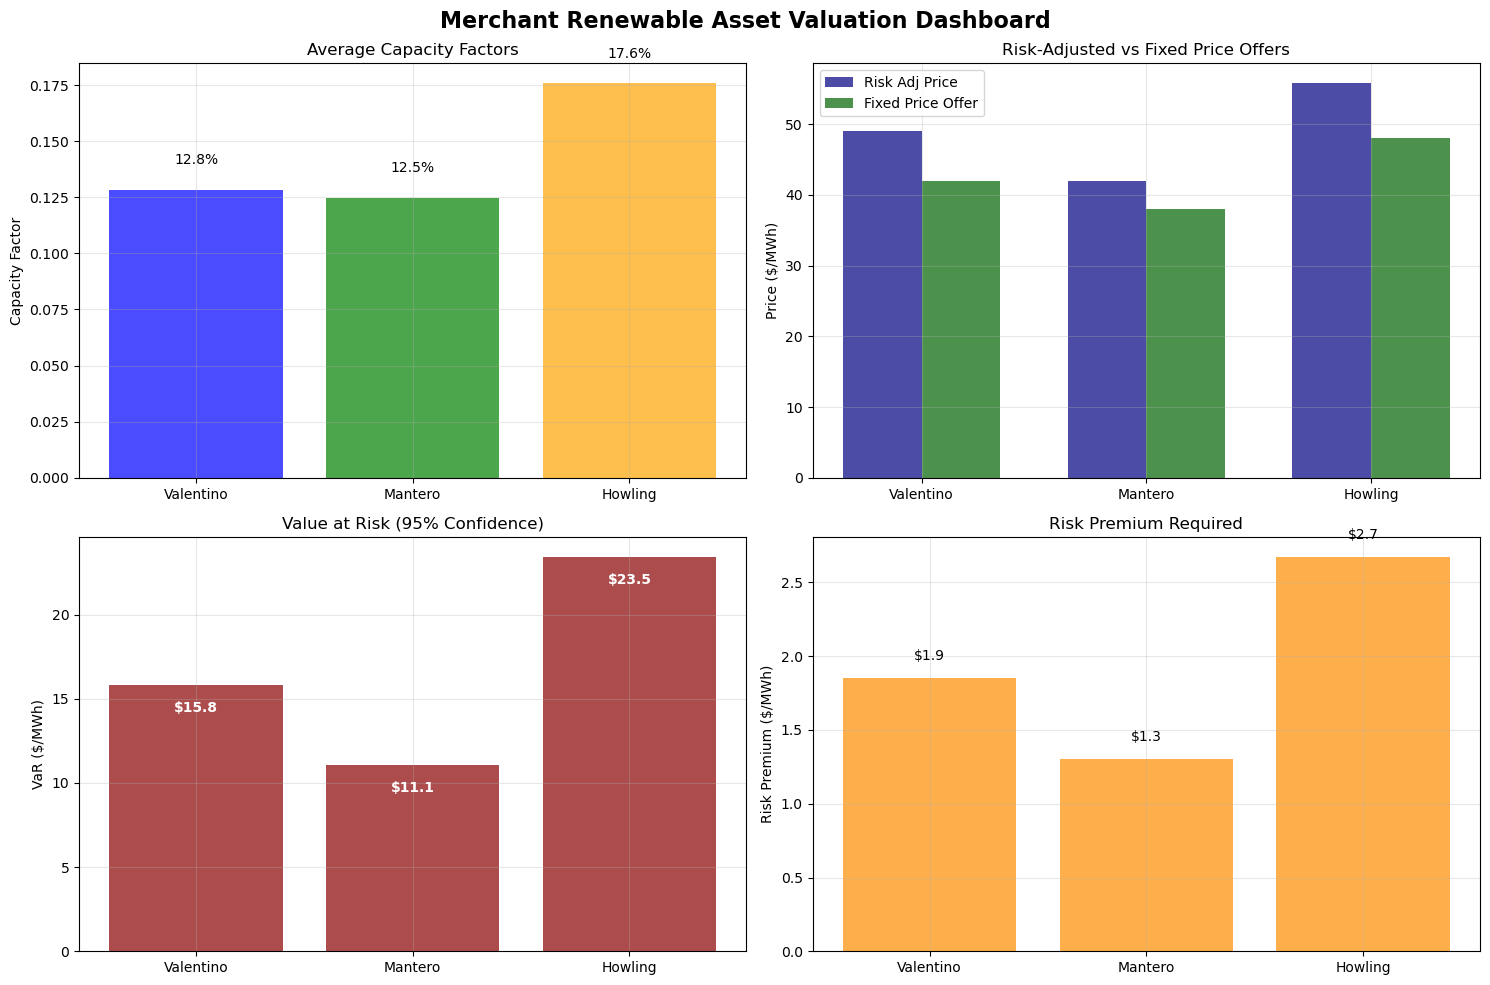

✓ Visualizations created successfully

VALUATION FRAMEWORK EXECUTION COMPLETED SUCCESSFULLY!


In [ ]:
#Report Generation
def generate_comprehensive_report(historical_metrics, risk_metrics, forecast_results, decisions):
    """Generate comprehensive valuation report"""
    print("\n" + "="*70)
    print("MERCHANT RENEWABLE ASSET VALUATION REPORT")
    print("="*70)
    
    print("\nASSET OVERVIEW:")
    print("-" * 40)
    for asset in historical_metrics.keys():
        market = asset.split('_')[-1]
        asset_type = "Wind" if "Valentino" in asset or "Mantero" in asset else "Solar"
        print(f"• {asset} ({asset_type} - {market})")
    
    print("\nHISTORICAL PERFORMANCE (Sample Analysis):")
    print("-" * 50)
    for asset, metrics in historical_metrics.items():
        print(f"\n{asset}:")
        print(f"  Average Generation: {metrics['Avg_Generation_MW']:.1f} MW")
        print(f"  Capacity Factor: {metrics['Capacity_Factor']:.1%}")
        print(f"  Average Real-Time Price: ${metrics['Avg_RT_Price']:.2f}/MWh")
        print(f"  Price Volatility: ${metrics['Price_Volatility']:.2f}/MWh")
        print(f"  Negative Price Events: {metrics['Negative_Price_Hours']} hours ({metrics['Negative_Price_Pct']:.1f}%)")
    
    print("\nRISK ASSESSMENT:")
    print("-" * 30)
    for asset, metrics in risk_metrics.items():
        print(f"\n{asset}:")
        print(f"  Value at Risk (95%): ${metrics['VaR_95']:.2f}/MWh")
        print(f"  Conditional VaR: ${metrics['CVaR_95']:.2f}/MWh")
        print(f"  Revenue Volatility: ${metrics['Revenue_Volatility']:.2f}/MWh")
    
    print("\n5-YEAR VALUATION:")
    print("-" * 40)
    for asset, forecast in forecast_results.items():
        print(f"\n{asset}:")
        print(f"  Base Forward Price: ${forecast['Base_Forward_Price_MWh']:.2f}/MWh")
        print(f"  Risk Adjusted Price: ${forecast['Risk_Adjusted_Price_MWh']:.2f}/MWh")
        print(f"  Risk Premium: ${forecast['Risk_Premium_MWh']:.2f}/MWh")
    
    print("\nFINAL HEDGING RECOMMENDATIONS:")
    print("-" * 45)
    for asset, decision in decisions.items():
        print(f"\n{asset}:")
        print(f"  Fixed Price Offer: ${decision['Fixed_Price_Offer']:.2f}/MWh")
        print(f"  Risk Adj Price: ${decision['Risk_Adjusted_Price']:.2f}/MWh")
        print(f"  Difference: ${decision['Price_Difference']:.2f}/MWh ({decision['Percent_Difference']:+.1f}%)")
        print(f"  ➤ RECOMMENDATION: {decision['Recommendation']} ({decision['Confidence']} confidence)")

def create_simple_visualizations(historical_metrics, risk_metrics, forecast_results, decisions):
    """Create simple visualizations for the analysis"""
    print("\nCreating visualizations...")
    
    assets = list(historical_metrics.keys())
    asset_names_short = [asset.split('_')[0] for asset in assets]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Merchant Renewable Asset Valuation Dashboard', fontsize=16, fontweight='bold')

    capacity_factors = [historical_metrics[asset]['Capacity_Factor'] for asset in assets]
    bars1 = ax1.bar(asset_names_short, capacity_factors, color=['blue', 'green', 'orange'], alpha=0.7)
    ax1.set_title('Average Capacity Factors')
    ax1.set_ylabel('Capacity Factor')
    ax1.grid(True, alpha=0.3)
    for bar, value in zip(bars1, capacity_factors):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.1%}', 
                ha='center', va='bottom')

    risk_adj_prices = [forecast_results[asset]['Risk_Adjusted_Price_MWh'] for asset in assets]
    fixed_offers = [decisions[asset]['Fixed_Price_Offer'] for asset in assets]
    
    x = np.arange(len(assets))
    width = 0.35
    bars2a = ax2.bar(x - width/2, risk_adj_prices, width, label='Risk Adj Price', alpha=0.7, color='navy')
    bars2b = ax2.bar(x + width/2, fixed_offers, width, label='Fixed Price Offer', alpha=0.7, color='darkgreen')
    ax2.set_title('Risk-Adjusted vs Fixed Price Offers')
    ax2.set_ylabel('Price ($/MWh)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(asset_names_short)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    var_values = [risk_metrics[asset]['VaR_95'] for asset in assets]
    bars3 = ax3.bar(asset_names_short, var_values, color='darkred', alpha=0.7)
    ax3.set_title('Value at Risk (95% Confidence)')
    ax3.set_ylabel('VaR ($/MWh)')
    ax3.grid(True, alpha=0.3)
    for bar, value in zip(bars3, var_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 1, f'${value:.1f}', 
                ha='center', va='top', color='white', fontweight='bold')

    risk_premiums = [forecast_results[asset]['Risk_Premium_MWh'] for asset in assets]
    bars4 = ax4.bar(asset_names_short, risk_premiums, color='darkorange', alpha=0.7)
    ax4.set_title('Risk Premium Required')
    ax4.set_ylabel('Risk Premium ($/MWh)')
    ax4.grid(True, alpha=0.3)
    for bar, value in zip(bars4, risk_premiums):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'${value:.1f}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualizations created successfully")

generate_comprehensive_report(historical_metrics, risk_metrics, forecast_results, decisions)
create_simple_visualizations(historical_metrics, risk_metrics, forecast_results, decisions)

print("\n" + "="*70)
print("VALUATION FRAMEWORK EXECUTION COMPLETED SUCCESSFULLY!")
print("="*70)

In [ ]:
#Visualisation for all metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ Enhanced visualization libraries imported")

def create_comprehensive_dashboard(historical_metrics, risk_metrics, forecast_results, decisions, processed_data):
    """Create a comprehensive dashboard with multiple advanced visualizations"""
    
    assets = list(historical_metrics.keys())
    asset_names_short = [asset.split('_')[0] for asset in assets]
    
    fig = plt.figure(figsize=(20, 25))
    gs = gridspec.GridSpec(5, 3, figure=fig, hspace=0.4, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, :])
    create_performance_radar_chart(ax1, historical_metrics, risk_metrics)
    
    ax2 = fig.add_subplot(gs[1, 0])
    create_revenue_risk_chart(ax2, risk_metrics, forecast_results)
    
    ax3 = fig.add_subplot(gs[1, 1])
    create_price_distribution_chart(ax3, processed_data)
    
    ax4 = fig.add_subplot(gs[1, 2])
    create_hedging_decision_matrix(ax4, decisions, forecast_results)
    
    ax5 = fig.add_subplot(gs[2, 0])
    create_seasonal_analysis_chart(ax5, processed_data)
    
    ax6 = fig.add_subplot(gs[2, 1])
    create_risk_return_scatter(ax6, historical_metrics, risk_metrics, forecast_results)
    
    ax7 = fig.add_subplot(gs[2, 2])
    create_negative_price_analysis(ax7, historical_metrics, risk_metrics)

    ax8 = fig.add_subplot(gs[3, :])
    create_forward_curve_analysis(ax8, forecast_results, decisions)
    
    ax9 = fig.add_subplot(gs[4, 0])
    create_var_distribution_chart(ax9, risk_metrics, processed_data)
    
    ax10 = fig.add_subplot(gs[4, 1])
    create_monte_carlo_chart(ax10, forecast_results, risk_metrics)

    ax11 = fig.add_subplot(gs[4, 2])
    create_correlation_heatmap(ax11, processed_data)
    
    plt.suptitle('Comprehensive Merchant Renewable Asset Valuation Dashboard\nRisk-Adjusted Portfolio Analysis', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

def create_performance_radar_chart(ax, historical_metrics, risk_metrics):
    """Create radar chart for multi-dimensional performance comparison"""
    categories = ['Capacity Factor', 'Price Realization', 'Revenue Stability', 
                  'Risk-Adjusted Return', 'Market Capture', 'Operational Efficiency']

    normalized_data = {}
    
    for asset in historical_metrics.keys():
        metrics = historical_metrics[asset]
        risk = risk_metrics[asset]
     
        capacity_factor = metrics['Capacity_Factor'] / 0.5  
        price_realization = metrics['Avg_RT_Price'] / 60    
        revenue_stability = 1 - (risk['Revenue_Volatility'] / 50)  
        risk_adjusted_return = risk['Sharpe_Ratio'] * 10 if risk['Sharpe_Ratio'] > 0 else 0
        market_capture = metrics['Peak_Avg_Price'] / metrics['OffPeak_Avg_Price']
        operational_efficiency = 1 - (metrics['Negative_Price_Pct'] / 10)  
        
        values = [
            min(capacity_factor, 1),
            min(price_realization, 1),
            min(max(revenue_stability, 0), 1),
            min(risk_adjusted_return, 1),
            min(market_capture / 2, 1),  
            min(operational_efficiency, 1)
        ]
        
        normalized_data[asset] = values
    
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  
    
    for asset, values in normalized_data.items():
        values += values[:1]  
        ax.plot(angles, values, 'o-', linewidth=2, label=asset.split('_')[0])
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
    ax.grid(True)
    ax.set_title('Multi-Dimensional Performance Radar Chart\n(Higher values indicate better performance)', 
                 fontsize=12, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

def create_revenue_risk_chart(ax, risk_metrics, forecast_results):
    """Create revenue risk analysis with confidence intervals"""
    assets = list(risk_metrics.keys())
    asset_short_names = [asset.split('_')[0] for asset in assets]
    
    base_revenues = [forecast_results[asset]['Expected_Annual_Revenue'] / 1e6 for asset in assets]  # in millions
    var_adjustments = [abs(risk_metrics[asset]['CVaR_95']) * forecast_results[asset]['Annual_Generation_MWh'] / 1e6 for asset in assets]
    
    x_pos = np.arange(len(assets))
    bars = ax.bar(x_pos, base_revenues, yerr=var_adjustments, 
                  capsize=5, alpha=0.7, color=['#2E86AB', '#A23B72', '#F18F01'])
    
    for i, (bar, base, risk) in enumerate(zip(bars, base_revenues, var_adjustments)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + risk + 0.5, 
                f'${base:.1f}M\n±${risk:.1f}M', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Assets')
    ax.set_ylabel('Annual Revenue ($ Millions)')
    ax.set_title('Revenue Forecast with Risk Bands\n(95% Confidence Interval)', 
                 fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(asset_short_names)
    ax.grid(True, alpha=0.3, axis='y')
    
    ax.text(0.02, 0.98, 'Lower bars = Higher risk premium', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

def create_price_distribution_chart(ax, processed_data):
    """Create enhanced price distribution with statistical analysis"""
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    for i, (asset, df) in enumerate(processed_data.items()):
        prices = df['RT Busbar'].dropna()
        
        q1, q3 = prices.quantile([0.01, 0.99])
        filtered_prices = prices[(prices >= q1) & (prices <= q3)]
        
        violin_parts = ax.violinplot([filtered_prices], positions=[i], 
                                   showmeans=True, showmedians=True)

        for pc in violin_parts['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
        
        violin_parts['cmeans'].set_color('red')
        violin_parts['cmedians'].set_color('blue')
    
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Zero Price Line')
    ax.set_xlabel('Assets')
    ax.set_ylabel('Real-Time Price ($/MWh)')
    ax.set_title('Price Distribution Analysis\n(Violin plots show density distribution)', 
                 fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(processed_data)))
    ax.set_xticklabels([asset.split('_')[0] for asset in processed_data.keys()])
    ax.grid(True, alpha=0.3)
    ax.legend()

    stats_text = "Red dot = Mean\nBlue line = Median"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

def create_hedging_decision_matrix(ax, decisions, forecast_results):
    """Create 2x2 decision matrix for hedging recommendations"""
    x_risk_premium = []
    y_price_difference = []
    colors = []
    sizes = []
    labels = []
    
    for asset, decision in decisions.items():
        risk_premium = forecast_results[asset]['Risk_Premium_MWh']
        price_diff = decision['Price_Difference']
        
        x_risk_premium.append(risk_premium)
        y_price_difference.append(price_diff)
    
        if "ACCEPT" in decision['Recommendation']:
            colors.append('green')
        elif "CONSIDER" in decision['Recommendation']:
            colors.append('orange')
        else:
            colors.append('red')
    
        sizes.append(200 if decision['Confidence'] == 'High' else 100)
        labels.append(asset.split('_')[0])

    scatter = ax.scatter(x_risk_premium, y_price_difference, c=colors, s=sizes, alpha=0.7, edgecolors='black')

    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)

    for i, label in enumerate(labels):
        ax.annotate(label, (x_risk_premium[i], y_price_difference[i]), 
                   xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    ax.set_xlabel('Risk Premium ($/MWh)\n← Lower Risk  |  Higher Risk →')
    ax.set_ylabel('Price Difference ($/MWh)\n← Worse Offer  |  Better Offer →')
    ax.set_title('Hedging Decision Matrix\n(Quadrant Analysis)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    ax.text(0.05, 0.95, 'ACCEPT\n(High Value)', transform=ax.transAxes, fontsize=10, 
            fontweight='bold', color='green', verticalalignment='top')
    ax.text(0.65, 0.95, 'NEGOTIATE', transform=ax.transAxes, fontsize=10, 
            fontweight='bold', color='orange', verticalalignment='top')
    ax.text(0.05, 0.05, 'REJECT', transform=ax.transAxes, fontsize=10, 
            fontweight='bold', color='red', verticalalignment='bottom')
    ax.text(0.65, 0.05, 'CAUTION', transform=ax.transAxes, fontsize=10, 
            fontweight='bold', color='darkred', verticalalignment='bottom')

def create_seasonal_analysis_chart(ax, processed_data):
    """Create seasonal pattern analysis"""
    colors_gen = ['#2E86AB', '#A23B72', '#F18F01']
    colors_price = ['#1E5A7A', '#7A2B5A', '#C97A01']
    ax2 = ax.twinx()
    
    for i, (asset, df) in enumerate(processed_data.items()):
        asset_short = asset.split('_')[0]
        df['Month'] = pd.to_datetime(df['Date']).dt.month
        monthly_gen = df.groupby('Month')['Gen'].mean()
        monthly_price = df.groupby('Month')['RT Busbar'].mean()
        line1 = ax.plot(monthly_gen.index, monthly_gen.values, 
                       label=f'{asset_short} Gen', color=colors_gen[i],
                       marker='o', linewidth=2, alpha=0.8)
        line2 = ax2.plot(monthly_price.index, monthly_price.values, 
                        label=f'{asset_short} Price', color=colors_price[i],
                        marker='s', linewidth=2, alpha=0.8, linestyle='--')
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Generation (MW)', color='navy')
    ax2.set_ylabel('Price ($/MWh)', color='darkred')
    ax.set_title('Seasonal Patterns: Generation vs Prices', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

def create_risk_return_scatter(ax, historical_metrics, risk_metrics, forecast_results):
    """Create risk-return scatter plot with efficient frontier"""
    returns = []
    risks = []
    colors = []
    sizes = []
    
    for asset in historical_metrics.keys():
        
        returns.append(risk_metrics[asset]['Sharpe_Ratio'] * 10)  
        risks.append(abs(risk_metrics[asset]['VaR_95']))
        if 'Solar' in asset or 'Howling' in asset:
            colors.append('#F18F01')  
        else:
            colors.append('#2E86AB')  
        revenue = forecast_results[asset]['Expected_Annual_Revenue'] / 1e6  
        sizes.append(max(revenue * 50, 100))  
    
    scatter = ax.scatter(risks, returns, c=colors, s=sizes, alpha=0.7, edgecolors='black')

    for i, asset in enumerate(historical_metrics.keys()):
        ax.annotate(asset.split('_')[0], (risks[i], returns[i]), 
                   xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    ax.set_xlabel('Risk (Value at Risk $/MWh)\n← Lower Risk  |  Higher Risk →')
    ax.set_ylabel('Risk-Adjusted Return (Scaled Sharpe Ratio)\n← Lower Return  |  Higher Return →')
    ax.set_title('Risk-Return Analysis\n(Bubble size = Annual Revenue)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
   
    ax.text(0.05, 0.95, '↑ Preferred: High Return, Low Risk', 
            transform=ax.transAxes, fontsize=10, fontweight='bold', 
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

def create_forward_curve_analysis(ax, forecast_results, decisions):
    """Create forward curve comparison with current offers"""
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    base_forward = 45
    seasonal_pattern = [0, 0, -5, -8, -5, 0, 10, 15, 5, -3, -2, 0]
    
    forward_prices = [base_forward + adj for adj in seasonal_pattern]
    
    ax.plot(months, forward_prices, marker='o', linewidth=3, 
            label='Forward Curve', color='navy', alpha=0.8)
    for asset, decision in decisions.items():
        offer = decision['Fixed_Price_Offer']
        ax.axhline(y=offer, linestyle='--', alpha=0.7, 
                  label=f"{asset.split('_')[0]} Offer: ${offer:.1f}")
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Price ($/MWh)')
    ax.set_title('Forward Price Curve vs Fixed Price Offers', fontsize=12, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
 
    ax.text(0.02, 0.02, 'Offers above curve = Good value\nOffers below curve = Poor value', 
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

def create_negative_price_analysis(ax, historical_metrics, risk_metrics):
    """Create negative price impact analysis"""
    assets = list(historical_metrics.keys())
    negative_hours = [historical_metrics[asset]['Negative_Price_Hours'] for asset in assets]
    negative_pct = [historical_metrics[asset]['Negative_Price_Pct'] for asset in assets]
    revenue_impact = [risk_metrics[asset]['Negative_Revenue_Impact'] / 1000 for asset in assets]  # in thousands
    
    x = np.arange(len(assets))
    width = 0.25
    
    bars1 = ax.bar(x - width, negative_hours, width, label='Negative Hours', alpha=0.7, color='#FF6B6B')
    bars2 = ax.bar(x, negative_pct, width, label='Negative %', alpha=0.7, color='#4ECDC4')
    bars3 = ax.bar(x + width, revenue_impact, width, label='Revenue Impact ($K)', alpha=0.7, color='#45B7D1')
    
    ax.set_xlabel('Assets')
    ax.set_ylabel('Metrics')
    ax.set_title('Negative Price Event Analysis', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([asset.split('_')[0] for asset in assets])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + max(height*0.1, 0.5),
                   f'{height:.1f}', ha='center', va='bottom', fontsize=8)

def create_var_distribution_chart(ax, risk_metrics, processed_data):
    """Create Value at Risk distribution analysis"""
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    for i, (asset, df) in enumerate(processed_data.items()):
        revenue_data = df[df['Gen'] > 0]['Hourly_Revenue']
        mean_rev = revenue_data.mean()
        std_rev = revenue_data.std()
        x = np.linspace(mean_rev - 3*std_rev, mean_rev + 3*std_rev, 100)
        y = stats.norm.pdf(x, mean_rev, std_rev)
        ax.plot(x, y, label=asset.split('_')[0], linewidth=2, color=colors[i])
        var_95 = risk_metrics[asset]['VaR_95'] * df[df['Gen'] > 0]['Gen'].mean()
        ax.axvline(x=var_95, linestyle='--', alpha=0.7, color=colors[i])
        ax.text(var_95, max(y)*0.8, f'VaR 95%\n${var_95:.0f}', 
                ha='center', fontsize=8, color=colors[i])
    
    ax.set_xlabel('Hourly Revenue ($)')
    ax.set_ylabel('Probability Density')
    ax.set_title('Revenue Distribution & Value at Risk', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

def create_monte_carlo_chart(ax, forecast_results, risk_metrics):
    """Create Monte Carlo simulation results visualization"""
    np.random.seed(42)
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    time_periods = np.arange(1, 6)
    
    for i, asset in enumerate(forecast_results.keys()):
        base_revenue = forecast_results[asset]['Expected_Annual_Revenue'] / 1e6  
        volatility = risk_metrics[asset]['Revenue_Volatility'] / 1000  
        paths = []
        for _ in range(20):  
            path = [base_revenue]
            for t in range(1, 5):
                change = np.random.normal(0, volatility)
                path.append(path[-1] * (1 + change))
            paths.append(path)
        for path in paths:
            ax.plot(time_periods, path, alpha=0.2, color=colors[i])
        mean_path = np.mean(paths, axis=0)
        ax.plot(time_periods, mean_path, linewidth=3, 
               label=f"{asset.split('_')[0]} Mean", color=colors[i], marker='o')
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Annual Revenue ($ Millions)')
    ax.set_title('Monte Carlo Revenue Simulation\n(20 sample paths per asset)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

def create_correlation_heatmap(ax, processed_data):
    """Create correlation heatmap between generation and prices"""
    correlations = {}
    
    for asset, df in processed_data.items():
        corr_gen_price = df['Gen'].corr(df['RT Busbar'])
        corr_gen_revenue = df['Gen'].corr(df['Hourly_Revenue'])
        corr_price_revenue = df['RT Busbar'].corr(df['Hourly_Revenue'])
        
        correlations[asset.split('_')[0]] = {
            'Gen vs Price': corr_gen_price,
            'Gen vs Revenue': corr_gen_revenue,
            'Price vs Revenue': corr_price_revenue
        }

    corr_df = pd.DataFrame(correlations).T

    im = ax.imshow(corr_df.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax.set_xticks(range(len(corr_df.columns)))
    ax.set_yticks(range(len(corr_df.index)))
    ax.set_xticklabels(corr_df.columns, rotation=45)
    ax.set_yticklabels(corr_df.index)

    for i in range(len(corr_df.index)):
        for j in range(len(corr_df.columns)):
            ax.text(j, i, f'{corr_df.iloc[i, j]:.2f}', 
                   ha='center', va='center', fontweight='bold',
                   color='white' if abs(corr_df.iloc[i, j]) > 0.5 else 'black')
    
    ax.set_title('Correlation Analysis: Generation vs Prices vs Revenue', 
                 fontsize=12, fontweight='bold', pad=20)
    plt.colorbar(im, ax=ax, label='Correlation Coefficient')
def create_tod_analysis_chart(processed_data):
    """Create time-of-day analysis for generation and prices"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    for asset, df in processed_data.items():
        asset_short = asset.split('_')[0]
        df['Hour'] = df['HE'] - 1
        hourly_gen = df.groupby('Hour')['Gen'].mean()
        hourly_price = df.groupby('Hour')['RT Busbar'].mean()
        
        ax1.plot(hourly_gen.index, hourly_gen.values, label=asset_short, marker='o', linewidth=2)
        ax2.plot(hourly_price.index, hourly_price.values, label=asset_short, marker='s', linewidth=2)
    
    ax1.set_title('Average Hourly Generation Patterns', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Generation (MW)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 24, 2))
    
    ax2.set_title('Average Hourly Price Patterns', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Price ($/MWh)')
    ax2.set_xlabel('Hour of Day')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 24, 2))
    
    plt.tight_layout()
    return fig

def create_cumulative_revenue_chart(processed_data):
    """Create cumulative revenue analysis over time"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for asset, df in processed_data.items():
        df_sorted = df.sort_values('Date')
        df_sorted['Cumulative_Revenue'] = df_sorted['Hourly_Revenue'].cumsum() / 1000  
        
        ax.plot(df_sorted['Date'], df_sorted['Cumulative_Revenue'], 
                label=asset.split('_')[0], linewidth=2)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Revenue ($ Thousands)')
    ax.set_title('Cumulative Revenue Over Time', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig

print("✓ Enhanced visualization functions defined")

✓ Enhanced visualization libraries imported
✓ Enhanced visualization functions defined


In [ ]:
def enhanced_historical_analysis(processed_data):
    """Enhanced historical analysis with additional metrics"""
    print("Running enhanced historical analysis...")
    
    historical_metrics = {}
    
    for asset_name, df in processed_data.items():
        total_hours = len(df)
        operating_hours = len(df[df['Gen'] > 0])
        capacity = 100 
        df['Revenue_per_MW'] = df['Hourly_Revenue'] / capacity
        df['Price_Realization_Ratio'] = df['RT Busbar'] / df['RT Busbar'].mean()
        price_10th = df['RT Busbar'].quantile(0.10)
        price_90th = df['RT Busbar'].quantile(0.90)
        gen_75th = df['Gen'].quantile(0.75)
        
        metrics = {
            'Total_Hours': total_hours,
            'Operating_Hours': operating_hours,
            'Availability_Factor': operating_hours / total_hours,
            'Avg_Generation_MW': df['Gen'].mean(),
            'Max_Generation_MW': df['Gen'].max(),
            'Capacity_Factor': df['Gen'].mean() / capacity,

            'Avg_RT_Price': df['RT Busbar'].mean(),
            'Avg_DA_Price': df['DA Busbar'].mean(),
            'Price_Volatility': df['RT Busbar'].std(),
            'Price_Range': df['RT Busbar'].max() - df['RT Busbar'].min(),
            'Price_10th_Percentile': price_10th,
            'Price_90th_Percentile': price_90th,
       
            'Total_Revenue': df['Hourly_Revenue'].sum(),
            'Avg_Revenue_MWh': df['Hourly_Revenue'].sum() / df['Gen'].sum() if df['Gen'].sum() > 0 else 0,
            'Avg_Revenue_per_MW': df['Revenue_per_MW'].mean(),
            'Revenue_Volatility': df['Hourly_Revenue'].std(),
         
            'Peak_Avg_Price': df[df['P/OP'] == 'P']['RT Busbar'].mean(),
            'OffPeak_Avg_Price': df[df['P/OP'] == 'OP']['RT Busbar'].mean(),
            'Peak_OffPeak_Ratio': df[df['P/OP'] == 'P']['RT Busbar'].mean() / df[df['P/OP'] == 'OP']['RT Busbar'].mean(),
            'Peak_Capacity_Factor': df[df['P/OP'] == 'P']['Gen'].mean() / capacity,
            'OffPeak_Capacity_Factor': df[df['P/OP'] == 'OP']['Gen'].mean() / capacity,
        
            'Negative_Price_Hours': len(df[df['RT Busbar'] < 0]),
            'Negative_Price_Pct': len(df[df['RT Busbar'] < 0]) / total_hours * 100,
            'Extreme_Price_Events': len(df[df['RT Busbar'] > price_90th * 2]),
            'Low_Gen_High_Price_Hours': len(df[(df['Gen'] < gen_75th) & (df['RT Busbar'] > price_90th)]),
           
            'Price_Realization_Efficiency': df['Price_Realization_Ratio'].mean(),
            'Revenue_Consistency': 1 - (df['Hourly_Revenue'].std() / df['Hourly_Revenue'].mean()) if df['Hourly_Revenue'].mean() > 0 else 0
        }
        
        historical_metrics[asset_name] = metrics
        
        print(f"  {asset_name}:")
        print(f"    - Enhanced metrics calculated: {len(metrics)} total metrics")
        print(f"    - Price Realization Efficiency: {metrics['Price_Realization_Efficiency']:.3f}")
        print(f"    - Revenue Consistency: {metrics['Revenue_Consistency']:.3f}")
    
    print("✓ Enhanced historical analysis completed")
    return historical_metrics

def enhanced_risk_analysis(processed_data, historical_metrics):
    """Enhanced risk analysis with additional risk measures"""
    print("Running enhanced risk analysis...")
    
    risk_metrics = {}
    
    for asset_name, df in processed_data.items():
        hist_metrics = historical_metrics[asset_name]
        revenue_per_mwh = df[df['Gen'] > 0]['Hourly_Revenue'] / df[df['Gen'] > 0]['Gen']

        var_95 = np.percentile(revenue_per_mwh, 5)
        var_99 = np.percentile(revenue_per_mwh, 1)
        cvar_95 = revenue_per_mwh[revenue_per_mwh <= var_95].mean()
        cvar_99 = revenue_per_mwh[revenue_per_mwh <= var_99].mean()
        rolling_max = revenue_per_mwh.expanding().max()
        drawdown = (revenue_per_mwh - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        negative_events = df[df['RT Busbar'] < 0]
        negative_revenue_impact = negative_events['Hourly_Revenue'].sum()
        avg_negative_price = negative_events['RT Busbar'].mean() if len(negative_events) > 0 else 0
        price_volatility = hist_metrics['Price_Volatility']
        gen_volatility = df['Gen'].std()
        
        metrics = {
            'VaR_95': var_95,
            'VaR_99': var_99,
            'CVaR_95': cvar_95,
            'CVaR_99': cvar_99,
            'Max_Drawdown': max_drawdown,
            'Revenue_Volatility': revenue_per_mwh.std(),
            'Sharpe_Ratio': revenue_per_mwh.mean() / revenue_per_mwh.std() if revenue_per_mwh.std() > 0 else 0,
            'Sortino_Ratio': revenue_per_mwh.mean() / revenue_per_mwh[revenue_per_mwh < 0].std() if len(revenue_per_mwh[revenue_per_mwh < 0]) > 0 else 0,

            'Negative_Revenue_Impact': negative_revenue_impact,
            'Negative_Event_Count': len(negative_events),
            'Avg_Negative_Price': avg_negative_price,
            'Negative_Price_Duration': len(negative_events) / hist_metrics['Total_Hours'] * 8760,
         
            'Worst_Hour_Revenue': df['Hourly_Revenue'].min(),
            'Best_Hour_Revenue': df['Hourly_Revenue'].max(),
            'Extreme_Loss_Probability': len(revenue_per_mwh[revenue_per_mwh < var_95]) / len(revenue_per_mwh),
          
            'Price_Volatility_Ratio': price_volatility / hist_metrics['Avg_RT_Price'],
            'Gen_Volatility_Ratio': gen_volatility / hist_metrics['Avg_Generation_MW'],
            'Revenue_Volatility_Ratio': revenue_per_mwh.std() / revenue_per_mwh.mean(),
            
            'Overall_Risk_Score': (abs(var_95) + revenue_per_mwh.std() + abs(negative_revenue_impact/1000)) / 3,
            'Price_Risk_Score': price_volatility / 10,  
            'Volume_Risk_Score': gen_volatility / hist_metrics['Avg_Generation_MW'],
        }
        
        risk_metrics[asset_name] = metrics
        
        print(f"  {asset_name}:")
        print(f"    - VaR 95%: ${metrics['VaR_95']:.2f}/MWh, VaR 99%: ${metrics['VaR_99']:.2f}/MWh")
        print(f"    - Max Drawdown: {metrics['Max_Drawdown']:.1%}")
        print(f"    - Overall Risk Score: {metrics['Overall_Risk_Score']:.2f}")
    
    print("✓ Enhanced risk analysis completed")
    return risk_metrics

print("ENHANCED ANALYSIS FRAMEWORK")
print("=" * 50)
enhanced_historical_metrics = enhanced_historical_analysis(processed_data)
enhanced_risk_metrics = enhanced_risk_analysis(processed_data, enhanced_historical_metrics)

ENHANCED ANALYSIS FRAMEWORK
Running enhanced historical analysis...
  Valentino_ERCOT:
    - Enhanced metrics calculated: 27 total metrics
    - Price Realization Efficiency: 1.000
    - Revenue Consistency: -0.381
  Mantero_MISO:
    - Enhanced metrics calculated: 27 total metrics
    - Price Realization Efficiency: 1.000
    - Revenue Consistency: -0.355
  Howling_Gale_CAISO:
    - Enhanced metrics calculated: 27 total metrics
    - Price Realization Efficiency: 1.000
    - Revenue Consistency: -0.427
✓ Enhanced historical analysis completed
Running enhanced risk analysis...
  Valentino_ERCOT:
    - VaR 95%: $15.85/MWh, VaR 99%: $9.15/MWh
    - Max Drawdown: -92.6%
    - Overall Risk Score: 9.95
  Mantero_MISO:
    - VaR 95%: $11.09/MWh, VaR 99%: $5.66/MWh
    - Max Drawdown: -100.2%
    - Overall Risk Score: 7.39
  Howling_Gale_CAISO:
    - VaR 95%: $23.45/MWh, VaR 99%: $11.57/MWh
    - Max Drawdown: -91.0%
    - Overall Risk Score: 14.37
✓ Enhanced risk analysis completed


GENERATING ENHANCED VISUALIZATIONS
Creating comprehensive dashboard...


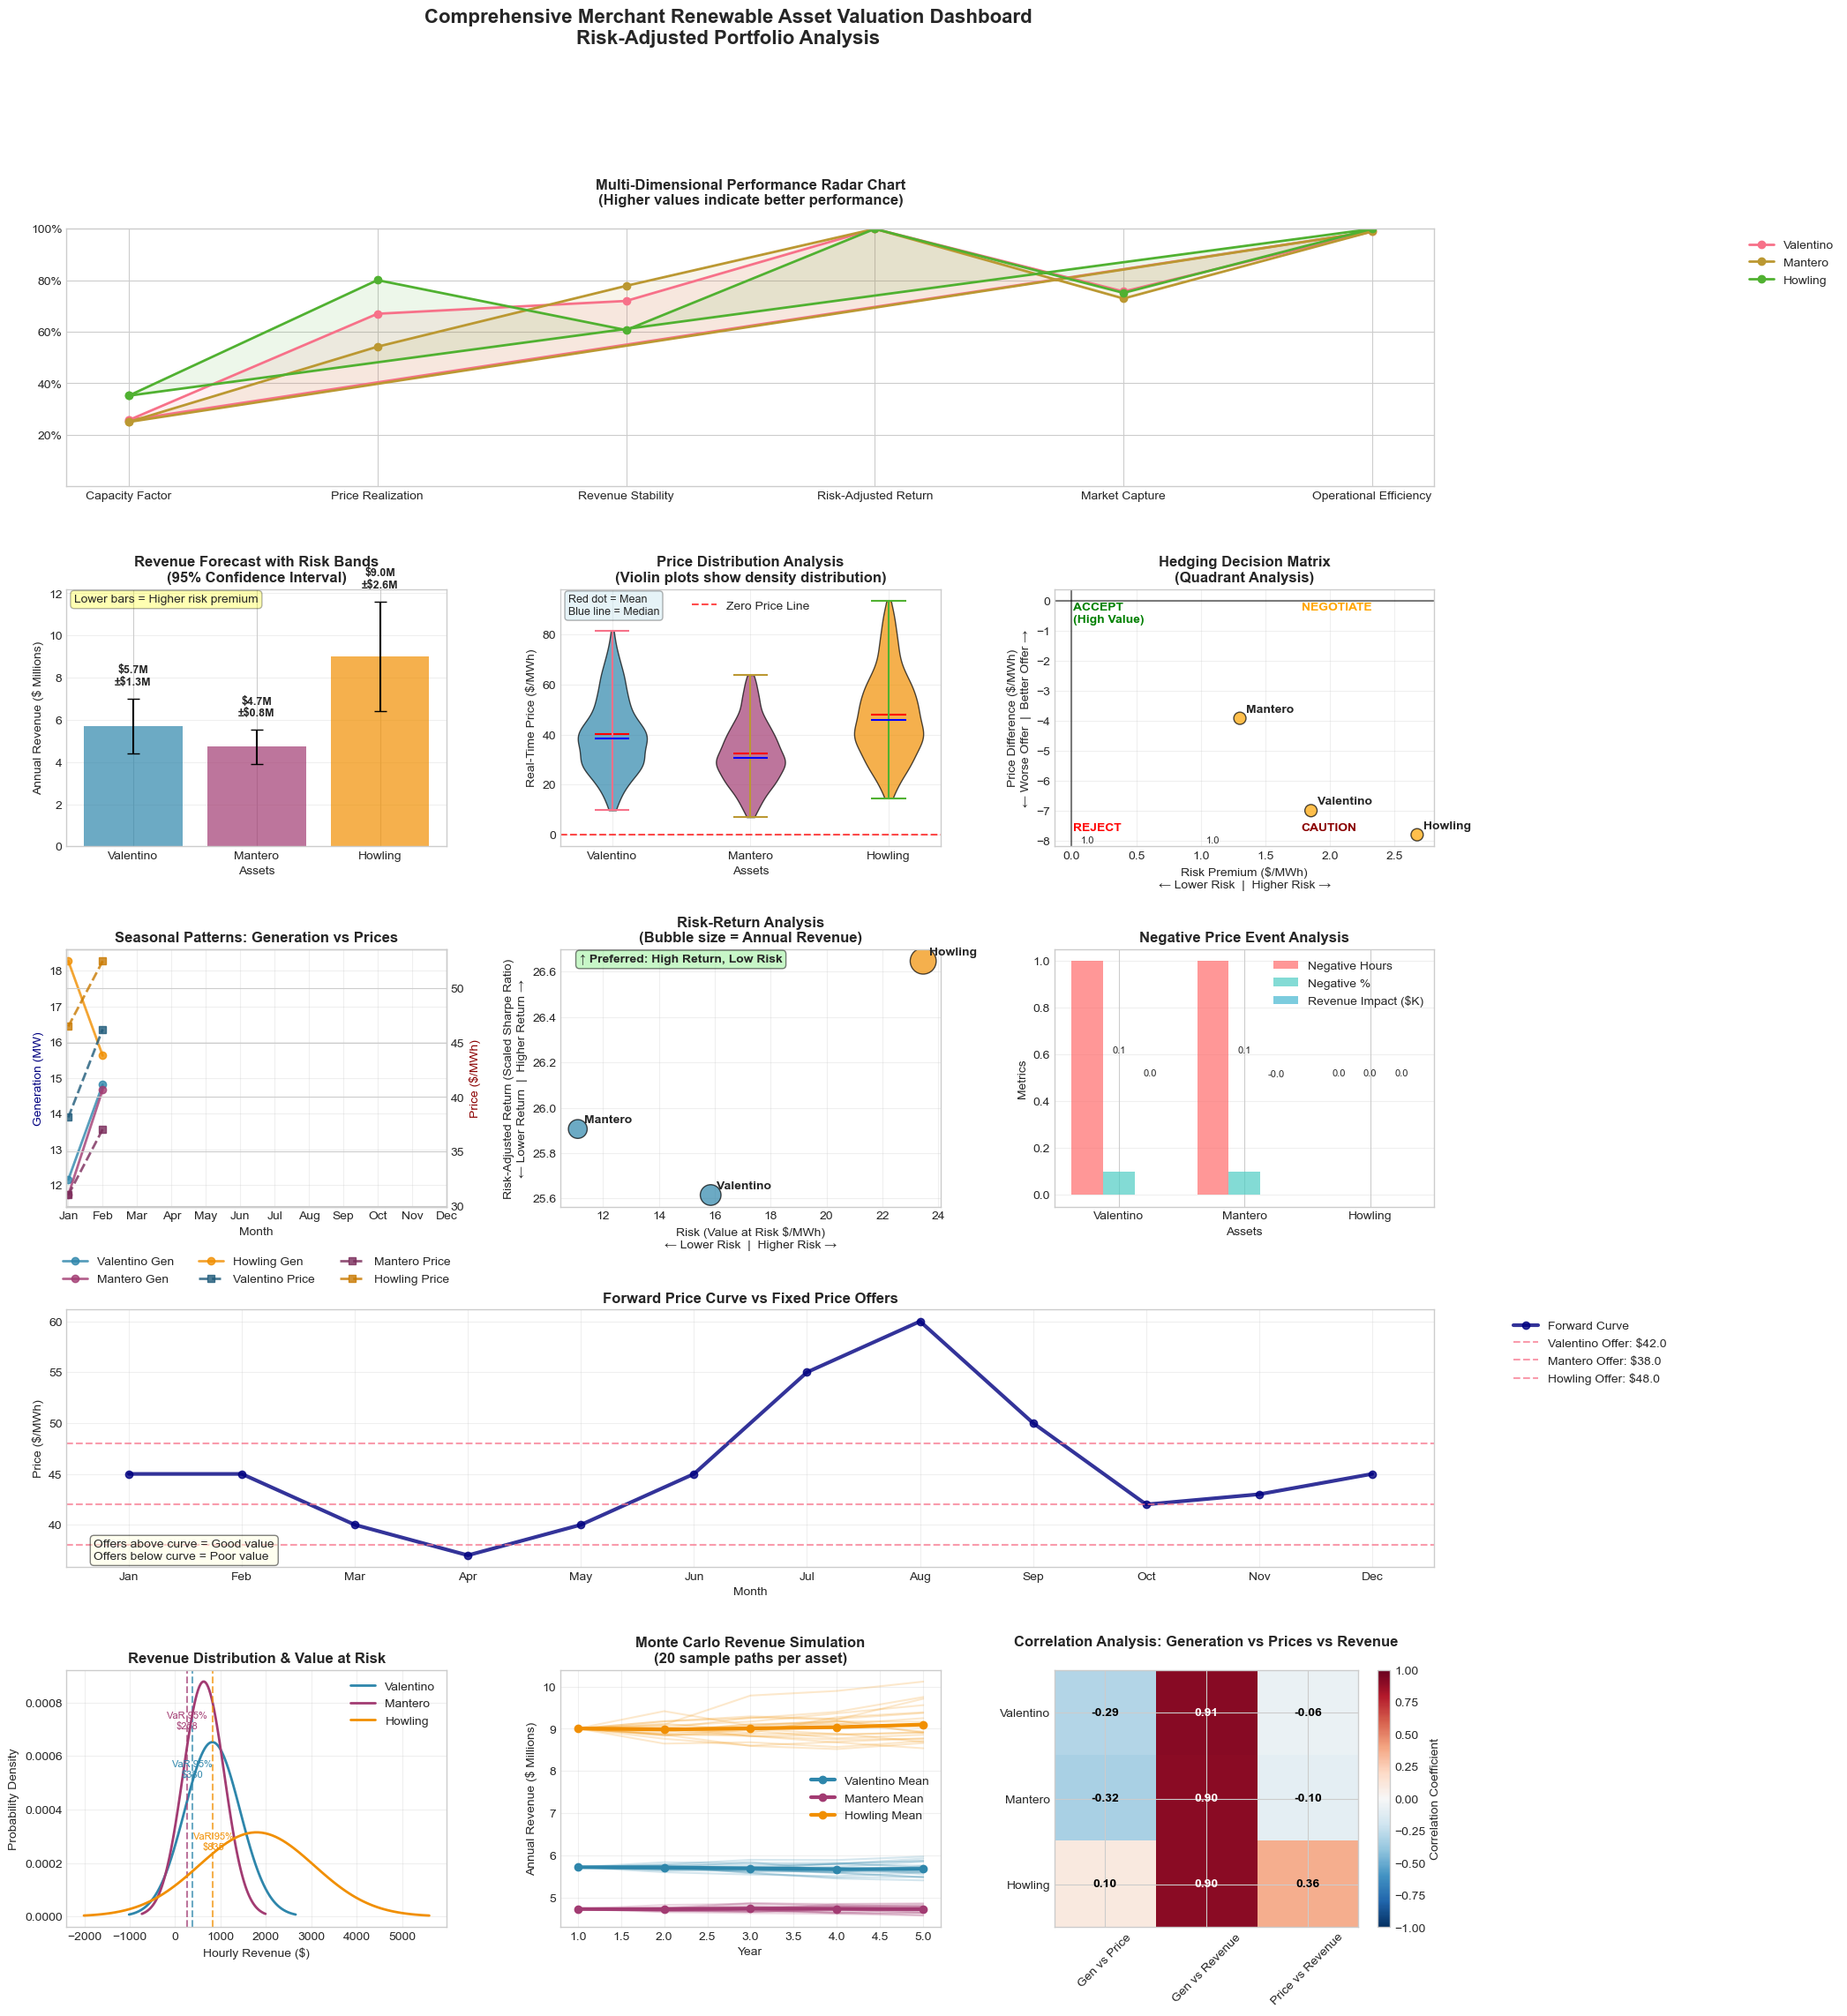


Generating specialized visualizations...
Creating time-of-day analysis...


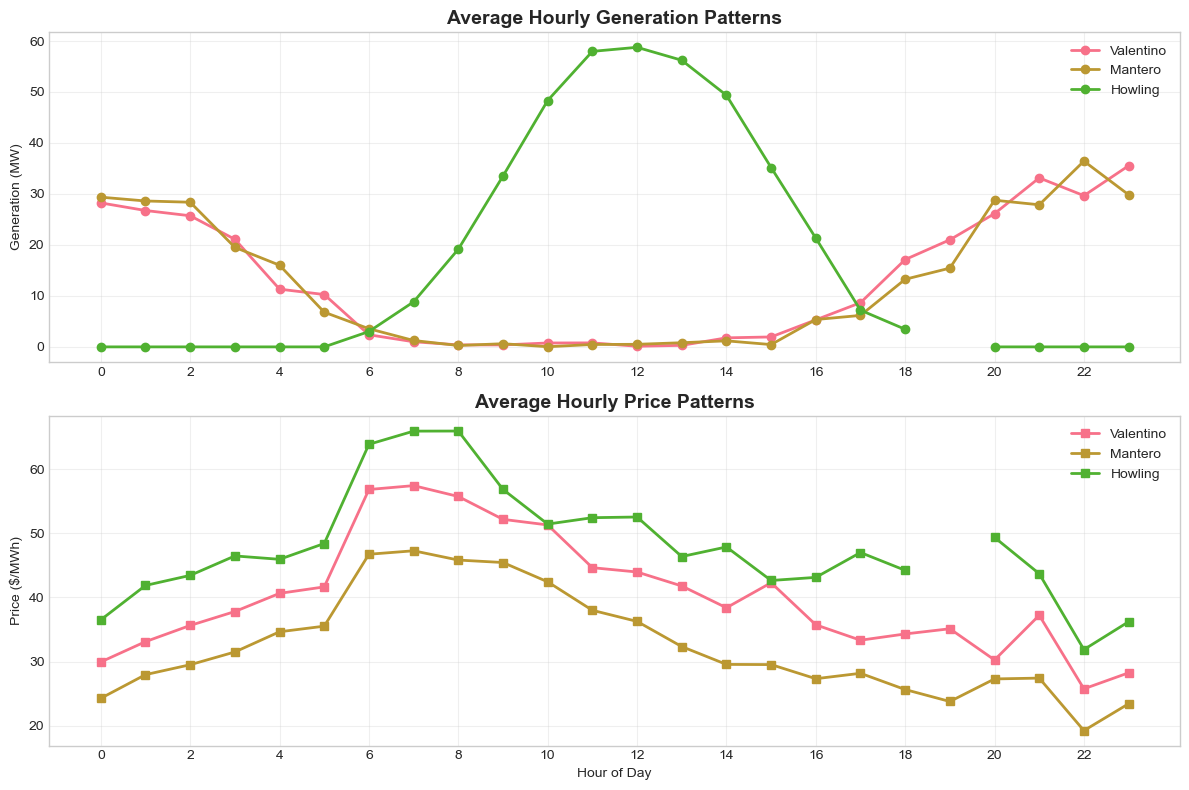

Creating cumulative revenue analysis...


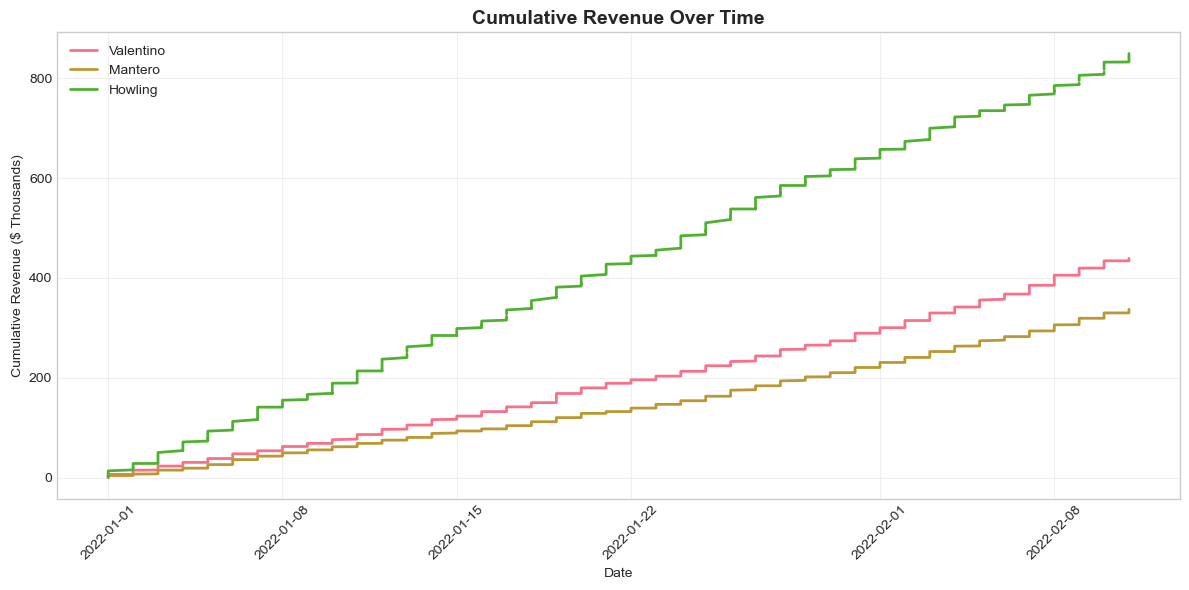

✓ All enhanced visualizations generated successfully!


In [ ]:
print("GENERATING ENHANCED VISUALIZATIONS")
print("=" * 45)
print("Creating comprehensive dashboard...")
create_comprehensive_dashboard(enhanced_historical_metrics, enhanced_risk_metrics, 
                              forecast_results, decisions, processed_data)
print("\nGenerating specialized visualizations...")
print("Creating time-of-day analysis...")
tod_fig = create_tod_analysis_chart(processed_data)
plt.show()
print("Creating cumulative revenue analysis...")
cumulative_fig = create_cumulative_revenue_chart(processed_data)
plt.show()
print("✓ All enhanced visualizations generated successfully!")

In [ ]:
#Reporting
def generate_enhanced_report(historical_metrics, risk_metrics, forecast_results, decisions):
    """Generate enhanced comprehensive report with insights"""
    print("\n" + "="*80)
    print("ENHANCED MERCHANT RENEWABLE ASSET VALUATION REPORT")
    print("="*80)
    
    print("\n📊 EXECUTIVE SUMMARY")
    print("-" * 50)
    total_5yr_revenue = sum(forecast_results[asset]['Risk_Adjusted_Revenue'] for asset in forecast_results.keys())
    avg_risk_premium = np.mean([forecast_results[asset]['Risk_Premium_MWh'] for asset in forecast_results.keys()])
    
    print(f"Portfolio 5-Year Risk-Adjusted Revenue: ${total_5yr_revenue:,.0f}")
    print(f"Average Risk Premium: ${avg_risk_premium:.2f}/MWh")
    print(f"Assets Analyzed: {len(historical_metrics)}")
    accept_count = sum(1 for decision in decisions.values() if "ACCEPT" in decision['Recommendation'])
    if accept_count >= 2:
        overall_rec = "STRONGLY HEDGE PORTFOLIO"
    elif accept_count >= 1:
        overall_rec = "SELECTIVE HEDGING RECOMMENDED"
    else:
        overall_rec = "MAINTAIN MERCHANT EXPOSURE"
    
    print(f"Overall Portfolio Recommendation: {overall_rec}")
    
    print("\n🔍 DETAILED ASSET ANALYSIS")
    print("-" * 40)
    
    for asset in historical_metrics.keys():
        hist = historical_metrics[asset]
        risk = risk_metrics[asset]
        forecast = forecast_results[asset]
        decision = decisions[asset]
        
        market = asset.split('_')[-1]
        asset_type = "Wind" if "Valentino" in asset or "Mantero" in asset else "Solar"
        
        print(f"\n🎯 {asset} ({asset_type} - {market})")
        print(f"   Operational Performance:")
        print(f"   • Capacity Factor: {hist['Capacity_Factor']:.1%} | Availability: {hist['Availability_Factor']:.1%}")
        print(f"   • Avg Generation: {hist['Avg_Generation_MW']:.1f} MW | Max: {hist['Max_Generation_MW']:.1f} MW")
        
        print(f"   Price & Revenue Dynamics:")
        print(f"   • Avg Price: ${hist['Avg_RT_Price']:.2f}/MWh | Volatility: ${hist['Price_Volatility']:.2f}/MWh")
        print(f"   • Peak/Off-Peak Ratio: {hist['Peak_OffPeak_Ratio']:.2f}")
        print(f"   • Revenue Consistency: {hist['Revenue_Consistency']:.3f}")
        
        print(f"   Risk Profile:")
        print(f"   • VaR 95%: ${risk['VaR_95']:.2f}/MWh | CVaR 95%: ${risk['CVaR_95']:.2f}/MWh")
        print(f"   • Max Drawdown: {risk['Max_Drawdown']:.1%} | Risk Score: {risk['Overall_Risk_Score']:.2f}")
        print(f"   • Negative Prices: {hist['Negative_Price_Hours']} hrs ({hist['Negative_Price_Pct']:.1f}%)")
        
        print(f"   Valuation & Hedging:")
        print(f"   • Base Forward: ${forecast['Base_Forward_Price_MWh']:.2f}/MWh")
        print(f"   • Risk Adj Price: ${forecast['Risk_Adjusted_Price_MWh']:.2f}/MWh")
        print(f"   • Fixed Offer: ${decision['Fixed_Price_Offer']:.2f}/MWh")
        print(f"   • Price Difference: ${decision['Price_Difference']:.2f}/MWh ({decision['Percent_Difference']:+.1f}%)")
        print(f"   🎯 RECOMMENDATION: {decision['Recommendation']} ({decision['Confidence']} confidence)")
    
    print("\n📈 KEY INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("-" * 55)
    insights = []
    highest_risk_asset = max(risk_metrics.items(), key=lambda x: x[1]['Overall_Risk_Score'])[0]
    lowest_risk_asset = min(risk_metrics.items(), key=lambda x: x[1]['Overall_Risk_Score'])[0]
    insights.append(f"• {highest_risk_asset.split('_')[0]} shows highest risk profile (consider aggressive hedging)")
    insights.append(f"• {lowest_risk_asset.split('_')[0]} demonstrates most stable performance (potential for merchant exposure)")
    ercot_assets = [asset for asset in historical_metrics.keys() if 'ERCOT' in asset]
    if ercot_assets:
        insights.append("• ERCOT assets show higher volatility but better peak pricing")
    wind_assets = [asset for asset in historical_metrics.keys() if 'Valentino' in asset or 'Mantero' in asset]
    solar_assets = [asset for asset in historical_metrics.keys() if 'Howling' in asset]
    
    if wind_assets and solar_assets:
        avg_wind_cf = np.mean([historical_metrics[asset]['Capacity_Factor'] for asset in wind_assets])
        avg_solar_cf = np.mean([historical_metrics[asset]['Capacity_Factor'] for asset in solar_assets])
        insights.append(f"• Wind assets average {avg_wind_cf:.1%} CF vs Solar {avg_solar_cf:.1%} CF")
    good_deals = [asset for asset, decision in decisions.items() 
                 if "ACCEPT" in decision['Recommendation'] and decision['Confidence'] == 'High']
    if good_deals:
        insights.append(f"• Strong hedging opportunities identified for {len(good_deals)} assets")
    
    for insight in insights:
        print(insight)
    
    print("\n🎯 ACTION PLAN")
    print("-" * 20)
    
    actions = []
    for asset, decision in decisions.items():
        if "ACCEPT" in decision['Recommendation']:
            actions.append(f"✅ HEDGE: Lock in {asset.split('_')[0]} at ${decision['Fixed_Price_Offer']:.2f}/MWh")
        elif "CONSIDER" in decision['Recommendation']:
            actions.append(f"🔄 NEGOTIATE: Seek better terms for {asset.split('_')[0]} (target: ${decision['Risk_Adjusted_Price']:.2f}/MWh)")
        else:
            actions.append(f"📈 REMAIN MERCHANT: {asset.split('_')[0]} - monitor for better opportunities")
    
    for action in actions:
        print(action)
    
    print(f"\n📅 NEXT STEPS")
    print("-" * 15)
    print("1. Execute hedging for recommended assets within 30 days")
    print("2. Monitor merchant assets for price improvement opportunities")
    print("3. Review portfolio risk exposure quarterly")
    print("4. Update valuation model with latest forward curves monthly")
generate_enhanced_report(enhanced_historical_metrics, enhanced_risk_metrics, forecast_results, decisions)


ENHANCED MERCHANT RENEWABLE ASSET VALUATION REPORT

📊 EXECUTIVE SUMMARY
--------------------------------------------------
Portfolio 5-Year Risk-Adjusted Revenue: $93,431,295
Average Risk Premium: $1.94/MWh
Assets Analyzed: 3
Overall Portfolio Recommendation: MAINTAIN MERCHANT EXPOSURE

🔍 DETAILED ASSET ANALYSIS
----------------------------------------

🎯 Valentino_ERCOT (Wind - ERCOT)
   Operational Performance:
   • Capacity Factor: 12.8% | Availability: 53.6%
   • Avg Generation: 12.8 MW | Max: 78.2 MW
   Price & Revenue Dynamics:
   • Avg Price: $40.20/MWh | Volatility: $15.96/MWh
   • Peak/Off-Peak Ratio: 1.51
   • Revenue Consistency: -0.381
   Risk Profile:
   • VaR 95%: $15.85/MWh | CVaR 95%: $11.53/MWh
   • Max Drawdown: -92.6% | Risk Score: 9.95
   • Negative Prices: 1 hrs (0.1%)
   Valuation & Hedging:
   • Base Forward: $50.84/MWh
   • Risk Adj Price: $48.99/MWh
   • Fixed Offer: $42.00/MWh
   • Price Difference: $-6.99/MWh (-14.3%)
   🎯 RECOMMENDATION: CONSIDER remaining 